# Data investigation notebook
This notebook contains my analysis, investigation of data. The notebook has:

- Reading image as simple as possible way.
- Checking information about `EPSG:25832` and `EPSG:4326`.
- Thoughts about **partial reading** and options how to optimise it.
- Playing with `rasterio` framework.

In [1]:
# Imports
import logging

import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
from pathlib import Path
from PIL import Image
import numpy as np

In [2]:
log = logging.getLogger(__name__)
logging.basicConfig(format="[%(asctime)s] [%(levelname)s] %(message)s", level=logging.INFO)

[2025-01-12 15:11:11,932] [INFO] File metadata:
[2025-01-12 15:11:11,933] [INFO] {'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10000, 'height': 10000, 'count': 4, 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'), 'transform': Affine(0.1, 0.0, 462000.0,
       0.0, -0.1, 5767000.0)}


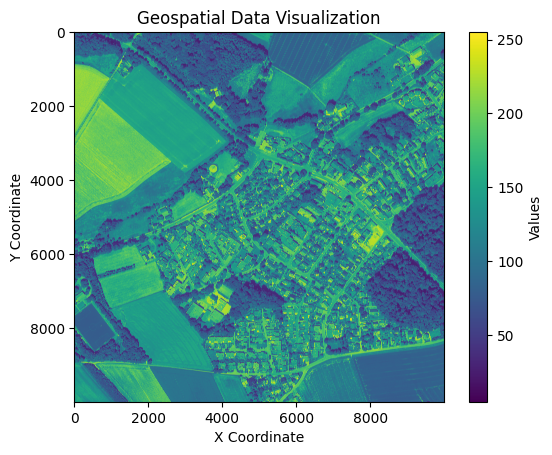

In [3]:
image_path = Path("/Users/ksafiullin/src/geospatial-data-processing/data/orthophotos/nw/dop10rgbi_32_462_5766_1_nw_2022.jp2")

with rasterio.open(image_path) as src:
    # Read the first band. #TODO: I need to understand what is the difference of these bands.
    data = src.read(1)

    # Display metadata about the file
    log.info("File metadata:")
    log.info(src.meta)

    # Plot the data
    plt.imshow(data, cmap="viridis")
    plt.colorbar(label="Values")
    plt.title("Geospatial Data Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

What does this number mean? I found possible values: `1`,`2`,`3`,`4`? Lets check was image changed or not.

Yes, some images have several _raster bands_. It's like a layers of image. However, it doesn't change my anything on my task so lets skip it. But good to know. 😁

[2025-01-12 15:14:30,627] [INFO] File metadata:
[2025-01-12 15:14:30,628] [INFO] {'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10000, 'height': 10000, 'count': 4, 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'), 'transform': Affine(0.1, 0.0, 462000.0,
       0.0, -0.1, 5767000.0)}


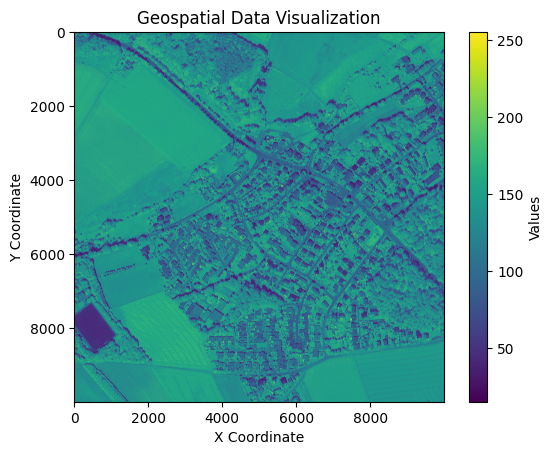

In [4]:
image_path = Path("/Users/ksafiullin/src/geospatial-data-processing/data/orthophotos/nw/dop10rgbi_32_462_5766_1_nw_2022.jp2")

with rasterio.open(image_path) as src:
    # Read the 4th band just to see the difference.
    data = src.read(4)

    log.info("File metadata:")
    log.info(src.meta)

    # Plot the data
    plt.imshow(data, cmap="viridis")
    plt.colorbar(label="Values")
    plt.title("Geospatial Data Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

Okay now I know - it's just an image. LARGE image. I have to deal with partial loading image. That's not possible to work and wait >1 minute to load one image, I need to reprioritise my scope. I will google any possible python libs that allows to load partially image.  

Basically, there are several ways how to speed up processes: 
- Use frameworks like `rasterio`, `GDAL`. 
- Transform image to `GeoTIFF` file format. Furthermore, these frameworks work better with `GeoTIFF` format as well.
    * Advantage: 
        - It will speed up reading opeation (efficient **partial reads**. )
        - The file format compatible with cloud (AWS S3, GCS etc).
        - More optimized for web or **network-based streaming**. The company gave a tip about network optimisation. Maybe this indirect suggestion, that company wrote on `challendge.md`, was about `GeoTIFF`.
    - Super **big** disadvantage: I need a lot of time of preprocessing **one time** (convert `jp2` -> `GeoTIFF`) but it makes big benefit in the future (Write Once - Read Many).

Okay for now lets focus on reading image **partially** with `rasterio` and `.jp2` file format. Why `rasterio`? Because it has more features than `GDAL` on more high level and this library is written on top of `GDAL`. Furthermore, it's popular solution, so it means most probaly I will find more answers on internet of my future issues/bottlenecks. If I had time in a future, I will think more about `GeoTIFF` file format.

---

Yes!  I can read `.jp2` partially with `rasterio`. So I reduce image reading time from 1 minute to 2 seconds. Good, right?

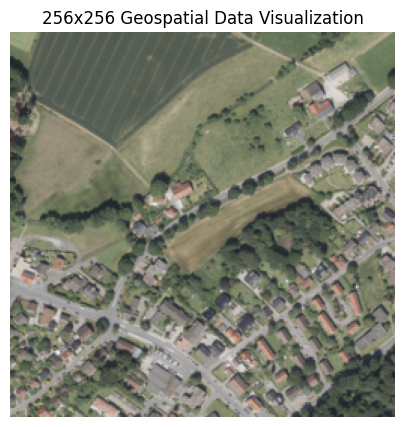

In [7]:
image_path = Path("/Users/ksafiullin/src/geospatial-data-processing/data/orthophotos/nw/dop10rgbi_32_462_5766_1_nw_2022.jp2")

left = 462500    
bottom = 5766500 
right = 463000   
top = 5767000    

with rasterio.open(image_path) as src:
    window = from_bounds(left, bottom, right, top, transform=src.transform)

    # Prepare image to show
    partial_rgb = src.read([1, 2, 3], window=window)
    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_rgb = np.clip(partial_rgb, 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(partial_rgb, mode="RGB")
    pil_img_256 = pil_img.resize((256, 256), resample=Image.BILINEAR)

    # Plot the data
    plt.figure(figsize=(5, 5))
    plt.imshow(pil_img_256)
    plt.title("256x256 Geospatial Data Visualization")
    plt.axis("off")
    plt.show()

# General FAQ

Now let's focus on the input data. We need to clarify the difference between **EPSG:25832** and **EPSG:4326**, and whether other coordinate formats could affect our plan. Below is a small glossary to address these topics:

> **Required Technical Skills**: Knowledge of Geospatial data handling, GIS, and Coordinate Reference Systems (CRS)

> The provided notebook will download a sample of 64 orthophotos, a small subset of the full dataset.  
> They cover a rectangular region from `462000,5766000` to `469999,5773999` in EPSG:25832 CRS.  
> Each image is a `.jp2` file with a resolution of `10000x10000` pixels.  
> Notice that the filenames in this dataset encode geospatial coordinate ranges. For example,  
> `dop10rgbi_32_280_5659_1_nw_2021.jp2` corresponds to a latitude range of `280,000` to `280,999`  
> and a longitude range of `5659,000` to `5659,999` in EPSG:25832.

```python
# TODO: Implement this function. Feel free to change the function signature if necessary.
def get_image(lat: float, long: float, radius: float = 100) -> Image.Image:
    raise NotImplementedError("This function is not implemented yet.")

# The function usage will look like:
get_image(51.962291, 7.626426, 100)
```

## Geospatial Data Handling

> Geospatial (or spatial) data represents objects, features, or phenomena on Earth's surface, typically with associated locations (coordinates).

**Data Types**  
- **Raster Data**: Grid-based (pixel) images such as satellite imagery or orthophotos. Each cell has a value (e.g., color or elevation).  
- **Vector Data**: Points, lines, and polygons for boundaries, roads, or any discrete features (e.g., city locations, country borders).

**Common Tasks**  
- **Data Storage**: Storing spatial data in structured files or databases (e.g., GeoTIFF for rasters, GeoPackage/PostGIS for vectors).  
- **Data Processing**: Clipping, mosaicking, resampling, etc.  
- **Analysis**: Overlays, buffer calculations, distance measurements, etc.  
- **Visualization**: Generating maps or interactive layers with coordinate-accurate overlays.

## GIS (Geographic Information Systems)

A system or framework for capturing, storing, visualizing, and analyzing geospatial data. Examples include **QGIS**, **ArcGIS**, and Python libraries like **GDAL**, **Rasterio**, and **GeoPandas**.

**Core Functions**  
- **Mapping**: Displaying data in a geographic context.  
- **Analysis**: Spatial joins, clustering, interpolation, and suitability analysis.  
- **Data Management**: Importing/exporting multiple formats, handling metadata.  
- **Key Benefit**: Combine multiple datasets (roads, rivers, imagery, demographics) in a consistent spatial coordinate system, then run queries or produce professional-quality maps.


## Coordinate Reference Systems

A Coordinate Reference System describes how to interpret coordinates so they match real-world locations accurately.

**Geographic vs. Projected**  

- **Geographic CRS (e.g., [EPSG:4326/WGS84](https://epsg.io/4326))**  
  - Coordinates are in degrees of latitude and longitude, e.g. `(51.962291, 7.626426)`.  
  - Valid ranges: **Latitude** from -90° to +90°, **Longitude** from -180° to +180°.  
  - Suitable for global data, but distances and areas can be distorted.

- **Projected CRS (e.g., [EPSG:25832/UTM 32N](https://epsg.io/25832))**  
  - Coordinates in linear units (usually meters), e.g. easting=`469999`, northing=`5773999`.  
  - Created by projecting the Earth's curved surface onto a flat plane.  
  - Helps make distance and area measurements more accurate within a region.


## Conclusion

From the information above, the input data for our function appears to be in **EPSG:4326/WGS84** coordinates because EPSG:25832 typically has much larger numeric ranges (hundreds of thousands or more). We will convert the input format to **EPSG:25832** internally.

If the user provides coordinates outside the valid EPSG:4326 ranges (latitude below -90 or above 90, longitude below -180 or above 180), we will raise a `ValueError`:

    if not (-90 <= lat <= 90 and -180 <= long <= 180):
        raise ValueError("Input coordinates must be in EPSG:4326 latitude/longitude degrees.")

If the user accidentally sends EPSG:25832 values (e.g., 462000, 5766000), the function will fail with this error message since those coordinates are out of range for EPSG:4326.

Regarding the `radius` parameter, it is typically up to 100 meters, but we will allow larger values. We will raise a warning if `radius` exceeds 100 meters because it may affect performance.

---

## Next Steps

1. **Create a simple pipeline** that partially reads `.jp2` images.  
2. **Stitch and resize** the fetched areas into a `256x256` pixel output.  
3. **Ignore edge cases** (e.g., unavailability of certain tiles), possibly returning a black image labeled "Data not available" in a future version.  
4. **Focus** on meeting the core goal with simplicity and efficiency. We will defer additional features or complex architectures until later.

**References**  
- [Official EPSG Registry for EPSG:4326](https://epsg.io/4326)  
- [Official EPSG Registry for EPSG:25832](https://epsg.io/25832)  
- [pyproj for CRS transformations](https://pyproj4.github.io/pyproj/stable/)  
- [Rasterio Docs](https://rasterio.readthedocs.io/en/latest/)

## Next steps

Next steps would be creating first `dumb` pipeline version with partial image reading and giving image in `256x256` pixels! For **NOW** lets ignoring edge cases (e.g. give black image with `Data is not available.` label if there is no image)

> ❗️ Solution will focus on fit target `goal`, `simplicity` and `efficiency`. No cool-fancy feature, complicated structure, archecture and so on.